In [46]:
import tensorflow as tf
from tensorflow.keras import preprocessing, layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import LeakyReLU

import keras
import random
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from IPython.display import Image


tf.config.threading.set_intra_op_parallelism_threads(32)
tf.config.threading.set_inter_op_parallelism_threads(32)

## The CWoLa method Relies on Model Separation of Mixed Samples
A model that is trained to separate mixed samples with a disproportionate amount of signal-like peak of features will be optimal for separating signal events from background events.  These mixed samples are shown in the following figure:

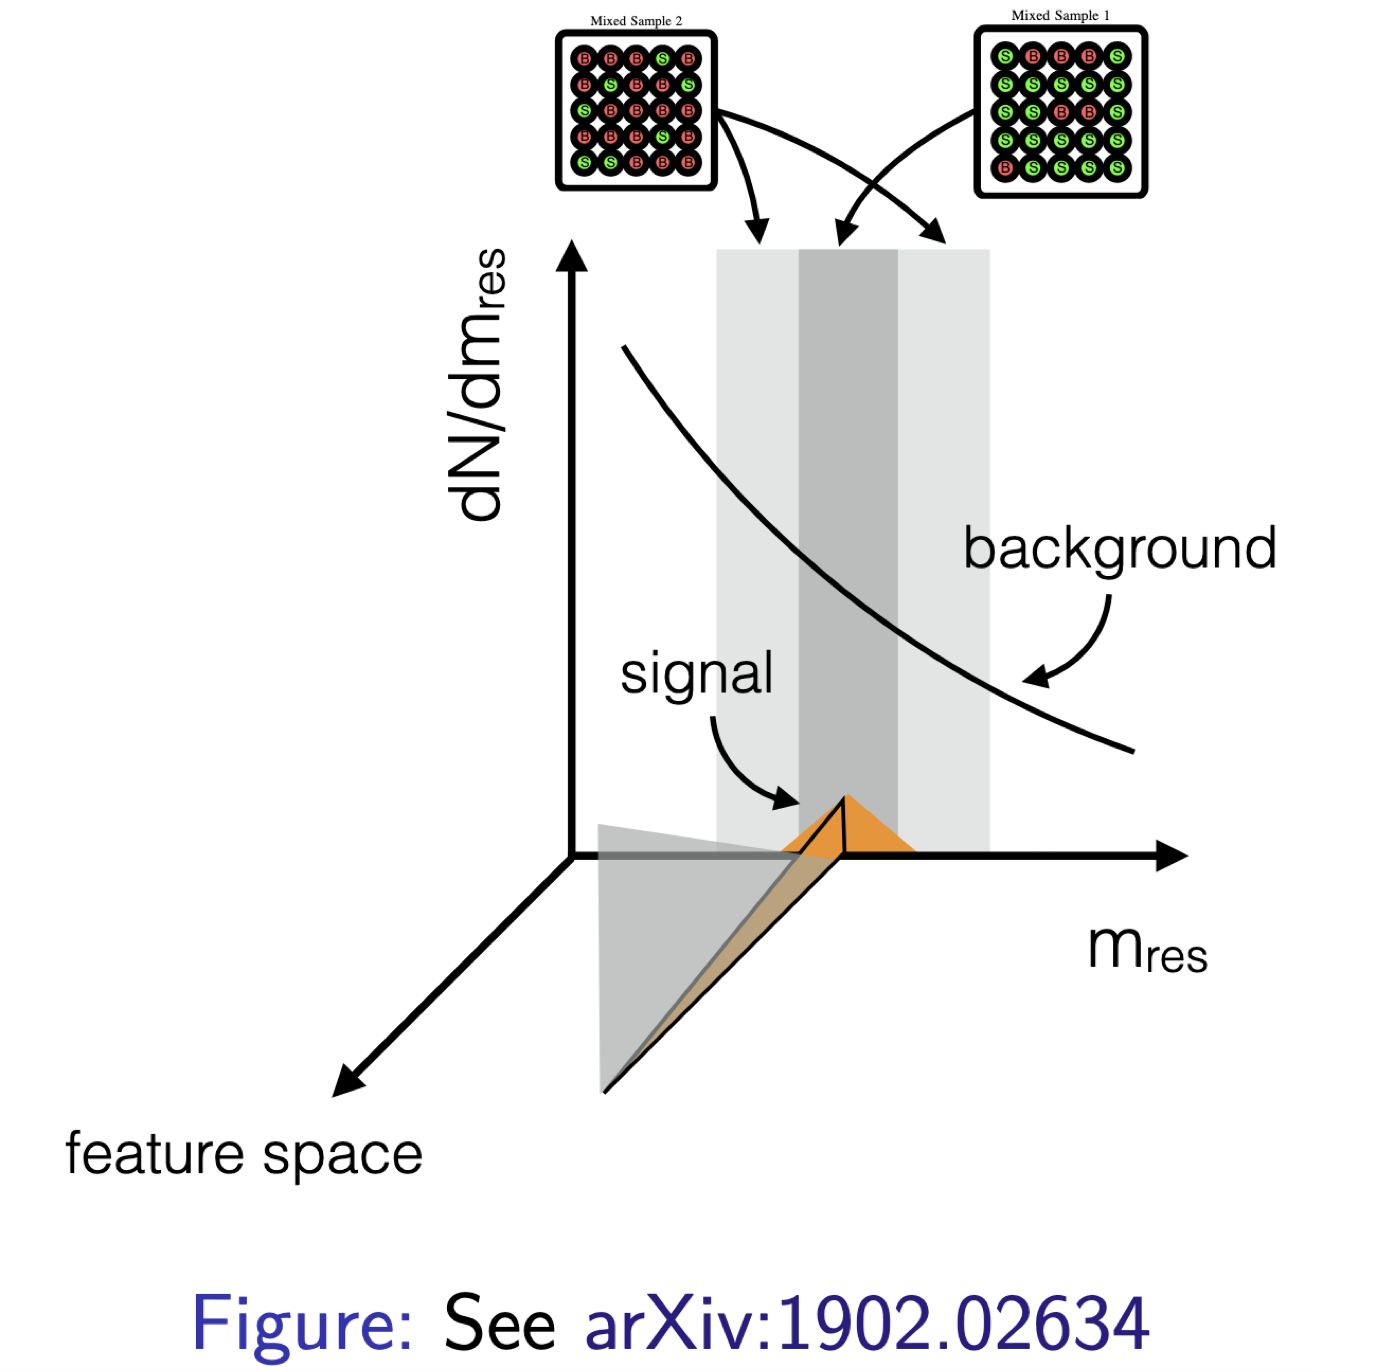

In [25]:
display(Image(filename="cwola.png", width = 500))

## First We Define the Toy Signal and Background Feature Distributions
The events at the LHC follow smooth probability distributions that can be approximated with simple analytic functions.

The features we pull from are:

    The pT distribution   - the jet momentum distribution: this follows a simple power-law function
    The Eta distribution  - the jet longitudinal angle: this follows a gaussian-like function
    The Phi distribution  - the jet transverse angle: this is flat and the jets are back-to-back
    The Mass distribution - the jet mass distribution: These are peaked at 0 for QCD events and have a 
                            wider distribution for signal
    The PTF distribution  - the pT fraction of prompt associated tracks: this is rapidly falling from 0 for
                            signal and Gaussian peaked at 0.5 for QCD background
    The Mjj distribution  - the invariant mass distribution for signal is Gaussian at 2 TeV with 10-20% width
    
    
We will train on 5 features that are chosen using physics arguments.  We expect differing distributions of jet masses, the jets' prompt associated-track pT fraction, and the event's |y*| separation (longitudinal separation).

In [28]:
def sampleFromCDF(x,y,numb):
    cdf = np.cumsum(y)
    cdf = cdf / cdf[-1]
    values = np.random.rand(numb)
    value_bins = np.searchsorted(cdf, values)
    bins = x[value_bins]
    return bins

def pullFromPt(a=1.0, b=-4.0, c=0.0, numberToPull=1000000):
    CoM = 13000.0 # Center of Mass energy
    
    x = np.linspace(500.0, 8000.0, 10000) / CoM
    y = a * x**b * (1 - x)**c
    
    returnPt = sampleFromCDF(x, y, numberToPull)
    assert np.all(returnPt > 0.0)
            
    return CoM*returnPt

def pullFromEta(sigma=2.4, numberToPull=1000000):
    x = np.linspace(-3.2, 3.2, 10000)
    y = np.exp(-x**2 / (2.0*sigma**2))
    
    returnEta = sampleFromCDF(x, y, numberToPull)
    
    return returnEta

def pullFromPhi(sigma=8.0, numberToPull=1000000):
    x = np.linspace(-3.2, 3.2, 10000)
    y = np.ones(len(x))
    
    returnPhi = sampleFromCDF(x, y, numberToPull)
    
    return returnPhi


def pullFromM(a=1.0, b=-2.0, c=0.0, numberToPull=1000000):
    CoM = 13000.0 # Center of Mass energy
    
    x = np.linspace(1.0, 500.0, 10000) / CoM
    y = a * x**b * (1 - x)**c
    
    returnM = sampleFromCDF(x, y, numberToPull)
    assert np.all(returnM > 0.0)

    return CoM*returnM

def pullFromPTF(mean=0.5, sigma=0.5, numberToPull=1000000):
    x = np.linspace(0.0, 1.0, 10000)
    y = np.exp(-(x - mean)**2 / (2.0*sigma**2))

    returnPTF = sampleFromCDF(x, y, numberToPull)
    assert np.all(returnPTF >= 0.0)

    return returnPTF

def pullFromMjj(mean=2000.0, sigma=400.0, numberToPull=1000000):
    x = np.linspace(1000.0, 3000.0, 10000)
    y = np.exp(-(x - mean)**2 / (2.0*sigma**2))

    returnMjj = sampleFromCDF(x, y, numberToPull)
    assert np.all(returnMjj > 0.0)

    return returnMjj

numberOfBackgroundToGenerate = int(1e7)
mjj_bkg   = np.zeros(numberOfBackgroundToGenerate)
type_bkg  = np.zeros(numberOfBackgroundToGenerate)

pt0_bkg, pt1_bkg      = pullFromPt(numberToPull=numberOfBackgroundToGenerate),  pullFromPt(numberToPull=numberOfBackgroundToGenerate)  
eta0_bkg, eta1_bkg    = pullFromEta(numberToPull=numberOfBackgroundToGenerate), pullFromEta(numberToPull=numberOfBackgroundToGenerate)
phi0_bkg, m0_bkg, m1_bkg  = pullFromPhi(numberToPull=numberOfBackgroundToGenerate), pullFromM(numberToPull=numberOfBackgroundToGenerate),   pullFromM(numberToPull=numberOfBackgroundToGenerate)
ptf0_bkg, ptf1_bkg    = pullFromPTF(numberToPull=numberOfBackgroundToGenerate), pullFromPTF(numberToPull=numberOfBackgroundToGenerate)
phi1_bkg          = phi0_bkg - 2.0*np.pi
ystar_bkg = abs(eta0_bkg - eta1_bkg)/2.0

for i in range(numberOfBackgroundToGenerate):
    if i % 100000 == 0:
        print("On event number ", i)
    
    t0, t1 = ROOT.TLorentzVector(), ROOT.TLorentzVector()
    t0.SetPtEtaPhiM(pt0_bkg[i], eta0_bkg[i], phi0_bkg[i], m0_bkg[i])
    t1.SetPtEtaPhiM(pt1_bkg[i], eta1_bkg[i], phi1_bkg[i], m1_bkg[i])
    mjj_bkg  [i] = (t0 + t1).M()
    
numberOfSignalToGenerate = int(4e4)
mjj_sig   = np.zeros(numberOfSignalToGenerate)
type_sig  = np.ones(numberOfSignalToGenerate)
pt0_sig, pt1_sig      = pullFromPt(numberToPull=numberOfSignalToGenerate),  pullFromPt(numberToPull=numberOfSignalToGenerate)  
eta0_sig, eta1_sig    = pullFromEta(numberToPull=numberOfSignalToGenerate, sigma=1.0), pullFromEta(numberToPull=numberOfSignalToGenerate, sigma=1.0)
phi0_sig, m0_sig, m1_sig  = pullFromPhi(numberToPull=numberOfSignalToGenerate), pullFromM(numberToPull=numberOfSignalToGenerate, b=-0.5),   pullFromM(numberToPull=numberOfSignalToGenerate, b=-1.0)
ptf0_sig, ptf1_sig    = pullFromPTF(numberToPull=numberOfSignalToGenerate, mean=0.0, sigma=0.05), pullFromPTF(numberToPull=numberOfSignalToGenerate, mean=0.0, sigma=0.05)
phi1_sig          = phi0_sig - 2.0*np.pi


mjj_sig = pullFromMjj(numberToPull=numberOfSignalToGenerate)
ystar_sig = abs(eta0_sig - eta1_sig)/2.0

i:  0
i:  100000
i:  200000
i:  300000
i:  400000
i:  500000
i:  600000
i:  700000
i:  800000
i:  900000
i:  1000000
i:  1100000
i:  1200000
i:  1300000
i:  1400000
i:  1500000
i:  1600000
i:  1700000
i:  1800000
i:  1900000
i:  2000000
i:  2100000
i:  2200000
i:  2300000
i:  2400000
i:  2500000
i:  2600000
i:  2700000
i:  2800000
i:  2900000
i:  3000000
i:  3100000
i:  3200000
i:  3300000
i:  3400000
i:  3500000
i:  3600000
i:  3700000
i:  3800000
i:  3900000
i:  4000000
i:  4100000
i:  4200000
i:  4300000
i:  4400000
i:  4500000
i:  4600000
i:  4700000
i:  4800000
i:  4900000
i:  5000000
i:  5100000
i:  5200000
i:  5300000
i:  5400000
i:  5500000
i:  5600000
i:  5700000
i:  5800000
i:  5900000
i:  6000000
i:  6100000
i:  6200000
i:  6300000
i:  6400000
i:  6500000
i:  6600000
i:  6700000
i:  6800000
i:  6900000
i:  7000000
i:  7100000
i:  7200000
i:  7300000
i:  7400000
i:  7500000
i:  7600000
i:  7700000
i:  7800000
i:  7900000
i:  8000000
i:  8100000
i:  8200000
i:  8300000
i:  840

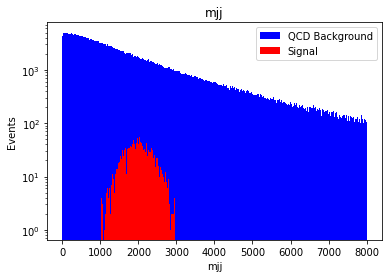

In [45]:
# Let's plot the signal and background distributions

h = plt.hist(mjj_bkg, color='b', label="QCD Background", bins=np.linspace(0, 8000.0, 8000))  # arguments are passed to np.histogram
plt.title("mjj")
plt.xlabel('mjj')
plt.ylabel('Events')
plt.yscale('log')
h = plt.hist(mjj_sig, color='r', label="Signal", bins=np.linspace(0, 8000.0, 8000))  # arguments are passed to np.histogram
l = plt.legend()

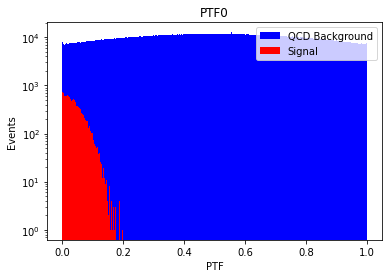

In [30]:
h = plt.hist(ptf0_bkg, color='b', label="QCD Background", bins=np.linspace(0, 1.0, 1000))  # arguments are passed to np.histogram
plt.title("PTF0")
plt.xlabel('PTF')
plt.ylabel('Events')
plt.yscale('log')
h = plt.hist(ptf0_sig, color='r', label="Signal", bins=np.linspace(0, 1.0, 1000))  # arguments are passed to np.histogram
l = plt.legend()

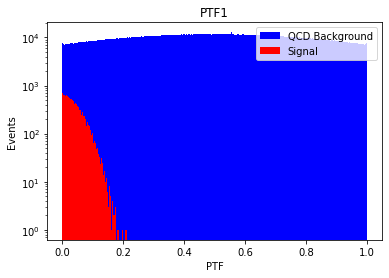

In [31]:
h = plt.hist(ptf1_bkg, color='b', label="QCD Background", bins=np.linspace(0, 1.0, 1000))  # arguments are passed to np.histogram
plt.title("PTF1")
plt.xlabel('PTF')
plt.ylabel('Events')
plt.yscale('log')
h = plt.hist(ptf1_sig, color='r', label="Signal", bins=np.linspace(0, 1.0, 1000))  # arguments are passed to np.histogram
l = plt.legend()

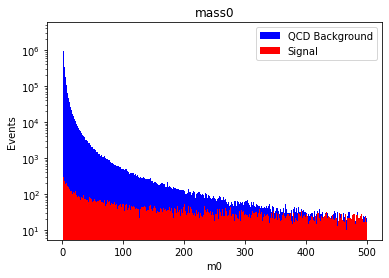

In [32]:
h = plt.hist(m0_bkg, color='b', label="QCD Background", bins=np.linspace(0, 500.0, 1000))  # arguments are passed to np.histogram
plt.title("mass0")
plt.xlabel('m0')
plt.ylabel('Events')
plt.yscale('log')
h = plt.hist(m0_sig, color='r', label="Signal", bins=np.linspace(0, 500.0, 1000))  # arguments are passed to np.histogram
l = plt.legend()

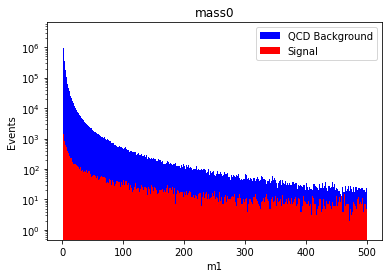

In [33]:
h = plt.hist(m1_bkg, color='b', label="QCD Background", bins=np.linspace(0, 500.0, 1000))  # arguments are passed to np.histogram
plt.title("mass0")
plt.xlabel('m1')
plt.ylabel('Events')
plt.yscale('log')
h = plt.hist(m1_sig, color='r', label="Signal", bins=np.linspace(0, 500.0, 1000))  # arguments are passed to np.histogram
l = plt.legend()

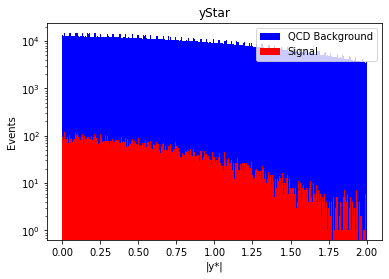

In [34]:
h = plt.hist(ystar_bkg, color='b', label="QCD Background", bins=np.linspace(0, 2.0, 1000))  # arguments are passed to np.histogram
plt.title("yStar")
plt.xlabel('|y*|')
plt.ylabel('Events')
plt.yscale('log')
h = plt.hist(ystar_sig, color='r', label="Signal", bins=np.linspace(0, 2.0, 1000))  # arguments are passed to np.histogram
l = plt.legend()

# Now Let's Train the Models!
The neural network model shape is 5x64x32x8x2.  Each of the following-defined bins with width 100 GeV becomes the signal bin, and a neural network is trained to separate these mixed samples.

In [9]:
mjj_bins = np.linspace(400, 8000, 2*38)
windowWidth = 5 # Number of bins on each side of a signal bin that define the sidebands
CR_lower = [max(0, binn - windowWidth*100) for binn in mjj_bins]
CR_upper = [min(mjj_bins[-1], binn + windowWidth*100) for binn in mjj_bins]
SR_lower = mjj_bins[:-1]
SR_upper = mjj_bins[1:]    

In [10]:
bkg_data = np.asarray([mjj_bkg, m0_bkg, m1_bkg, ptf0_bkg, ptf1_bkg, ystar_bkg, type_bkg]).T
sig_data = np.asarray([mjj_sig, m0_sig, m1_sig, ptf0_sig, ptf1_sig, ystar_sig, type_sig]).T
all_data = np.asarray(np.append(bkg_data, sig_data, axis=0))

np.random.shuffle(all_data)

all_mjj  = all_data[:,0]

In [11]:
def trainModel(X_train, X_test, y_train, y_test, class_weight, batch_size, learning_rate=1e-4, binn=0):
    
    strategy = tf.distribute.MirroredStrategy(devices=["/cpu:0"])
    with strategy.scope():

        fourLayer_model = tf.keras.Sequential([
            layers.Dense(64,     activation='relu', use_bias=True, bias_initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1), input_dim=5),
            layers.Dropout(0.1),
            layers.Dense(32,     activation='relu', use_bias=True, bias_initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1)),
            layers.Dense(8,      activation='relu', use_bias=True, bias_initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1)),
            layers.Dense(2,      activation="softmax", use_bias=True, bias_initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1)),
            ], )
        
        fourLayer_model.compile(loss = 'binary_crossentropy',
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=0.8, beta_2=0.99, epsilon=1e-08, decay=0.005),
        metrics=[tf.keras.metrics.AUC(name='prc', curve='PR'), tf.keras.metrics.AUC(name="auc")])

        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=1e-6, patience=10)
        
        history = fourLayer_model.fit(x=X_train, y=y_train, epochs=50, verbose=0, validation_data=(X_test, y_test),  batch_size=batch_size, class_weight=class_weight)

        test_acc = fourLayer_model.evaluate(x=X_test, y=y_test, verbose=2, batch_size=batch_size)

        fourLayer_model.save("model_NN_"+str(binn))

        return history

In [40]:
batch_size = int(0.001*len(all_data))#int(512*4)                                                                                                                                                   

for signalbin in range(len(mjj_bins)):
    
    print("signalbin: ", signalbin)
    
    # Select events from each control region (sideband)
    bin_data = all_data[(all_mjj >= CR_lower[signalbin]) & (all_mjj < CR_upper[signalbin])]
    bin_mjj  = all_mjj [(all_mjj >= CR_lower[signalbin]) & (all_mjj < CR_upper[signalbin])]

    # Define the 2-node classification (signal or sideband) event
    bin_class = np.zeros((len(bin_mjj), 2))
    bin_class[:,1][(bin_mjj >= SR_lower[signalbin]) & (bin_mjj <  SR_upper[signalbin])] = 1
    bin_class[:,0][(bin_mjj <  SR_lower[signalbin]) | (bin_mjj >= SR_upper[signalbin])] = 1

    # Crudely normalize the data and signal
    normed_data = (bin_data - bin_data.min())/ (bin_data.max() - bin_data.min())
    normed_data = normed_data[:,1:-1]
    
    # Split the combined data and signal into test and training data
    X_train, X_test, y_train, y_test = train_test_split(normed_data, bin_class, test_size=0.33, random_state=42)
    
    # Define the classification weight so that sideband and signal region events are equally weighted
    #class_weight = {0: 1.0/len(bin_class[:,0][bin_class[:,0] == 1])*len(bin_class)/2.0, 1: 1.0/len(bin_class[:,1][bin_class[:,1] == 1])*len(bin_class)/2.0}
    class_weight = {0: 1.0/len(y_train[:,0][y_train[:,0] == 1])*len(y_train)/2.0, 1: 1.0/len(y_train[:,1][y_train[:,1] == 1])*len(y_train)/2.0}
    
    hist = trainModel(X_train, X_test, y_train, y_test, class_weight, batch_size=batch_size, learning_rate=1e-4, binn=signalbin)
    
    acc      = hist.history['auc']
    val_acc  = hist.history['val_auc']
    prc      = hist.history['prc']
    val_prc  = hist.history['val_prc']
    loss     = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training AUC')
    plt.plot(epochs, val_acc, 'r', label='Validation AUC')
    plt.title('Training and validation AUC for ' + str(int(SR_lower[signalbin])) + " to " + str(int(SR_upper[signalbin])))
    plt.legend()
    plt.savefig("auc_"+str(signalbin)+".png")
    plt.close()
    
    plt.plot(epochs, prc, 'ro', label='Training PRAUC')
    plt.plot(epochs, val_prc, 'r', label='Validation PRAUC')
    plt.title('Training and validation PRAUC for ' + str(int(SR_lower[signalbin])) + " to " + str(int(SR_upper[signalbin])))
    plt.legend()
    plt.savefig('prauc_'+str(signalbin)+'.png')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss for ' + str(int(SR_lower[signalbin])) + " to " + str(int(SR_upper[signalbin])))
    plt.legend()
    plt.savefig('loss_'+str(signalbin)+'.png')
    plt.close()


signalbin:  0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
127/127 - 1s - loss: 0.6930 - prc: 0.4754 - auc: 0.4777
INFO:tensorflow:Assets written to: model_NN_0/assets
signalbin:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
138/138 - 1s - loss: 0.6906 - prc: 0.8424 - auc: 0.8847
INFO:tensorflow:Assets written to: model_NN_1/assets
signalbin:  2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
133/133 - 1s - loss: 0.6916 - prc: 0.7735 - auc: 0.8216
INFO:tensorflow:Assets written to: model_NN_2/assets
signalbin:  3
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
127/127 - 1s - loss: 0.6932 - prc: 0.4868 - auc: 0.4900
INFO:tensorflow:Assets written to: model_NN_3/assets
signalbin:  4
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/

KeyboardInterrupt: 

2022-05-28 22:32:31.719427: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_2094777"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

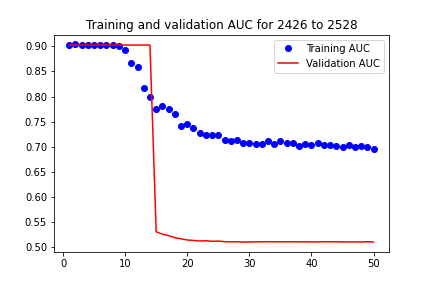

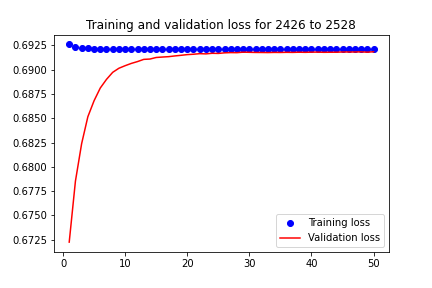

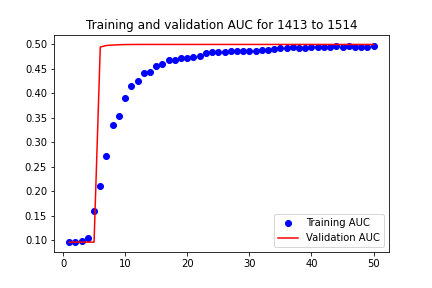

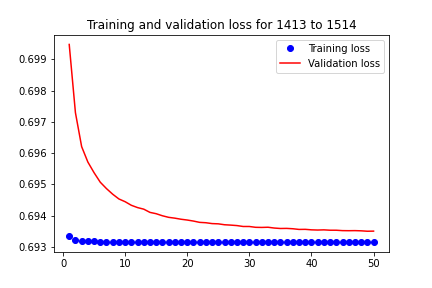

In [43]:
display(Image(filename='auc_20.png'))
display(Image(filename='loss_20.png'))

display(Image(filename='auc_10.png'))
display(Image(filename='loss_10.png'))

## Apply each trained Neural Network to each corresponding bin
We take the top 10% of events passing the "background-like" scores from the sideband data.  This quantile is 1 minus the probability of a signal-like event in the signal region.  

In [14]:
total_selected_data, total_selected_data_1p, total_data, total_selected_signal, total_selected_signal_1p, total_signal = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
signal_for_bin, selected_signal_for_bin, selected_signal_for_bin_1p = [], [], []
data_for_bin, selected_data_for_bin, selected_data_for_bin_1p = [], [], []

for signalbin in range(len(mjj_bins)-1):
    
    print("Applying NNs to signalbin: ", signalbin)
    
    bin_data = all_data[(all_mjj >= CR_lower[signalbin]) & (all_mjj < CR_upper[signalbin])]
    bin_mjj  = all_mjj [(all_mjj >= CR_lower[signalbin]) & (all_mjj < CR_upper[signalbin])]
    bin_class = np.zeros((len(bin_mjj), 2))
    
    bin_class[:,1][(bin_mjj >= SR_lower[signalbin]) & (bin_mjj <  SR_upper[signalbin])] = 1
    bin_class[:,0][(bin_mjj <  SR_lower[signalbin]) | (bin_mjj >= SR_upper[signalbin])] = 1

    normed_data = (bin_data - bin_data.min())/ (bin_data.max() - bin_data.min())
    normed_data = normed_data[:,1:-1]
    
    bestModel   = keras.models.load_model('model_NN_'+str(signalbin))
    scores      = bestModel(normed_data, training=False)[:,1]
    
    sorted_scores     = sorted(scores[bin_class[:,0] == 1].numpy())
    quantile          = sorted_scores[int(0.9*len(sorted_scores))]
    quantile_1percent = sorted_scores[int(0.99*len(sorted_scores))]

    pred          = scores > quantile
    pred_1percent = scores > quantile_1percent
    bin_signal    = (bin_data[:,-1] == 1)                                                                                                                                  
    bin_data      = (bin_data[:,-1] == 0)
    
    total_selected_data      += len(bin_mjj[(bin_class[:,1] == 1) & bin_data    & pred])
    total_selected_data_1p   += len(bin_mjj[(bin_class[:,1] == 1) & bin_data    & pred_1percent])
    total_data               += len(bin_mjj[(bin_class[:,1] == 1) & bin_data])
    total_selected_signal    += len(bin_mjj[(bin_class[:,1] == 1) & bin_signal  & pred])
    total_selected_signal_1p += len(bin_mjj[(bin_class[:,1] == 1) & bin_signal  & pred_1percent])
    total_signal             += len(bin_mjj[(bin_class[:,1] == 1) & bin_signal])

    data_for_bin            .append(len(bin_mjj[(bin_class[:,1] == 1) & bin_data]))
    selected_data_for_bin   .append(len(bin_mjj[(bin_class[:,1] == 1) & bin_data  & pred]))
    selected_data_for_bin_1p.append(len(bin_mjj[(bin_class[:,1] == 1) & bin_data  & pred_1percent]))
    
    if len(bin_mjj[(bin_class[:,1] == 1) & bin_signal]) > 15:
        signal_for_bin            .append(len(bin_mjj[(bin_class[:,1] == 1) & bin_signal]))
        selected_signal_for_bin   .append(len(bin_mjj[(bin_class[:,1] == 1) & bin_signal  & pred]))
        selected_signal_for_bin_1p.append(len(bin_mjj[(bin_class[:,1] == 1) & bin_signal  & pred_1percent]))
    else:
        signal_for_bin            .append(1.0)
        selected_signal_for_bin   .append(0.0)
        selected_signal_for_bin_1p.append(0.0)

signalbin:  0
signalbin:  1
signalbin:  2
signalbin:  3
signalbin:  4
signalbin:  5
signalbin:  6
signalbin:  7
signalbin:  8
signalbin:  9
signalbin:  10
signalbin:  11
signalbin:  12
signalbin:  13
signalbin:  14
signalbin:  15
signalbin:  16
signalbin:  17
signalbin:  18
signalbin:  19
signalbin:  20
signalbin:  21
signalbin:  22
signalbin:  23
signalbin:  24
signalbin:  25
signalbin:  26
signalbin:  27
signalbin:  28
signalbin:  29
signalbin:  30
signalbin:  31
signalbin:  32
signalbin:  33
signalbin:  34
signalbin:  35
signalbin:  36
signalbin:  37
signalbin:  38
signalbin:  39
signalbin:  40
signalbin:  41
signalbin:  42
signalbin:  43
signalbin:  44
signalbin:  45
signalbin:  46
signalbin:  47
signalbin:  48
signalbin:  49
signalbin:  50
signalbin:  51
signalbin:  52
signalbin:  53
signalbin:  54
signalbin:  55
signalbin:  56
signalbin:  57
signalbin:  58
signalbin:  59
signalbin:  60
signalbin:  61
signalbin:  62
signalbin:  63
signalbin:  64
signalbin:  65
signalbin:  66
signa

In [44]:
print("Total selected data at the 10% level: ", total_selected_data)
print("Total selected data at the 1% level: ", total_selected_data_1p)
print("Total data in the sample: ", total_data)
print("fraction of data at 10% score cut: ", total_selected_data / total_data)
print("fraction of data at 1% score cut:", total_selected_data_1p / total_data)

print("Total selected signal: ", total_selected_signal)
print("Total selected signal at the 1% level: ", total_selected_signal_1p)
print("Total signal in the sample: ", total_signal)
print("fraction of signal at 10% score cut: ", total_selected_signal / total_signal)
print("fraction of signal at 1% score cut: ", total_selected_signal_1p / total_signal)

Total selected data at the 10% level:  752475.0
Total selected data at the 1% level:  70464.0
Total data in the sample:  7824574.0
fraction of data at 10% score cut:  0.09616817477858859
fraction of data at 1% score cut: 0.009005474291635557
Total selected signal:  22229.0
Total selected signal at the 1% level:  10007.0
Total signal in the sample:  40000.0
fraction of signal at 10% score cut:  0.555725
fraction of signal at 1% score cut:  0.250175


# Wow, our signal efficiency is 55.6% and 25.0% for the two cuts
Assuming the amount of signal is much smaller than that of the background, a 10% random cut will reduce the signal sensitivity by a factor of 3.2.  So we need at least a signal efficiency of 32% in order to break even (10% for the 1% NN score cut).  So we're already ahead globally.  But we can examine the signal efficiency and signal sensitivity boost for each bin to observe the anti-tagging effect of the networks far from the signal peak.

In [18]:
def returnSOverSqrtBBoost(oldS, oldB, newS, newB):
    oldS, oldB, newS, newB = np.asarray(oldS), np.asarray(oldB), np.asarray(newS), np.asarray(newB)
    index = (oldB) > 0 & (newB > 0)
    return newS/np.sqrt(newB[index]) / ( oldS / np.sqrt(oldB[index]) )

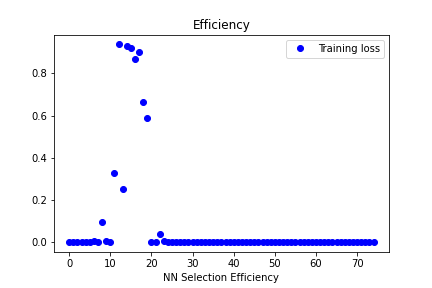

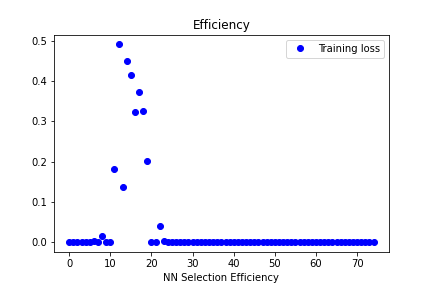

In [16]:
plt.figure()
plt.plot(np.asarray(selected_signal_for_bin)/np.asarray(signal_for_bin), 'bo', label='Training loss')
plt.title('Efficiency')
plt.xlabel('Bin Number')
plt.xlabel('NN Selection Efficiency')
plt.legend()
plt.savefig('bin_effs.png')
plt.close()
display(Image(filename='bin_effs.png'))

plt.figure()
plt.plot(np.asarray(selected_signal_for_bin_1p)/np.asarray(signal_for_bin), 'bo', label='Training loss')
plt.title('Efficiency')
plt.xlabel('Bin Number')
plt.xlabel('NN Selection Efficiency')
plt.legend()
plt.savefig('bin_effs_1percent.png')
plt.close()
display(Image(filename='bin_effs_1percent.png'))

#  Results
Wow, we have pretty remarkable signal efficiency in the center of the signal peak!
The ratios of the signal sensitivities before and after application of the neural networks is even more striking though.

/tmp/ipykernel_3732685/448939074.py:4: RuntimeWarning: invalid value encountered in true_divide
  return newS/np.sqrt(newB[index]) / ( oldS / np.sqrt(oldB[index]) )


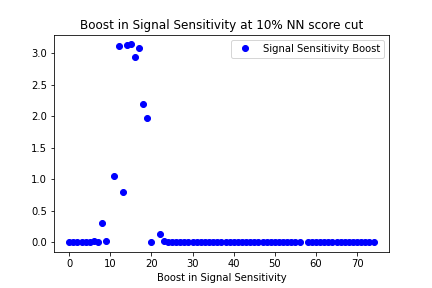

/tmp/ipykernel_3732685/448939074.py:4: RuntimeWarning: invalid value encountered in true_divide
  return newS/np.sqrt(newB[index]) / ( oldS / np.sqrt(oldB[index]) )


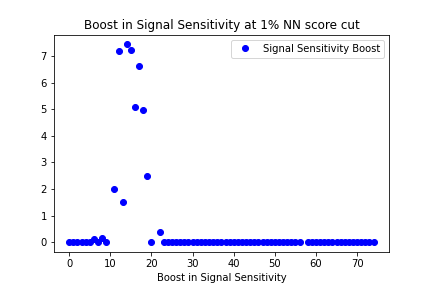

In [20]:
plt.figure()
plt.plot(returnSOverSqrtBBoost(signal_for_bin, data_for_bin, selected_signal_for_bin, selected_data_for_bin),\
         'bo', label='Signal Sensitivity Boost')
plt.title('Boost in Signal Sensitivity at 10% NN score cut')
plt.xlabel('Bin Number')
plt.xlabel('Boost in Signal Sensitivity')
plt.legend()
plt.savefig('sig_sense.png')
plt.close()
display(Image(filename='sig_sense.png'))

plt.figure()
plt.plot(returnSOverSqrtBBoost(signal_for_bin, data_for_bin, selected_signal_for_bin_1p, selected_data_for_bin_1p),\
         'bo', label='Signal Sensitivity Boost')
plt.title('Boost in Signal Sensitivity at 1% NN score cut')
plt.xlabel('Bin Number')
plt.xlabel('Boost in Signal Sensitivity')
plt.legend()
plt.savefig('sig_sense_1percent.png')
plt.close()
display(Image(filename='sig_sense_1percent.png'))
